# Извлечение именованных сущностей (NER)

Извлечение именованных сущностей (NER) - это задача в области обработки естественного языка, которая заключается в выделении и классификации конкретных объектов (сущностей) в тексте. Эти сущности могут включать в себя имена людей, организации, места, даты и другие типы информации.

## Цель NER

Цель NER состоит в том, чтобы автоматически распознавать и классифицировать конкретные фрагменты текста как определенные типы сущностей. Например, в предложении "Apple Inc. была основана Стивом Джобсом в Купертино в 1976 году", NER должно определить "Apple Inc." как организацию, "Стивом Джобсом" как имя человека, "Купертино" как местоположение и "1976 году" как дату.

NER имеет множество приложений, таких как:
- **Информационный поиск:** Позволяет уточнить запрос, ограничив результаты поиска по конкретным сущностям.
- **Извлечение информации:** Помогает автоматически извлекать ключевую информацию из текстов, упрощая анализ данных.
- **Автоматическая обработка языка:** Используется для лучшего понимания контекста и семантики текста.

## Как работает?

NER использует методы машинного обучения, основанные на алгоритмах классификации, чтобы определить, к какому классу относится каждая часть текста. Для этого требуется обучение модели на размеченных данных, где каждая сущность в тексте помечена определенным классом.

## Популярные инструменты для NER

Несколько популярных библиотек и инструментов для работы с NER включают:
- **Spacy:** Библиотека для обработки естественного языка, которая включает в себя инструменты для извлечения именованных сущностей.
- **NLTK (Natural Language Toolkit):** Библиотека на языке Python, предоставляющая инструменты для работы с текстом, включая NER.
- **Stanford NER:** Инструмент для обучения собственных моделей извлечения именованных сущностей.

# Загрузим данные

In [1]:
import pandas as pd

data = pd.read_csv('Datasets/ner_dataset.csv', encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [2]:
data.shape

(1048575, 4)

Мы можем видеть, что предложения разбиты на токены в столбце "Word". В столбце "Sentence #" номер предложения отображается один раз, а затем выводится NaN до начала следующего предложения.

## Вытащим необходимые части для нейронной сети
Для обучения нейронной сети мы будем использовать два параметра, приведенных ниже. Нейронная сеть будет принимать только целые числа в качестве входных данных. Преобразуем все уникальные токены в корпусе в соответствующий индекс.
- {token} в {token id}: адрес строки в матрице вложений для текущего токена.
- {tag} в {tag id}: векторы распределения вероятности истинности с one-hot кодированием для вычисления потерь на выходе сети.

In [3]:
def get_dict_map(data, token_or_tag):
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    idx2tok = {idx: tok for idx, tok in enumerate(vocab)}
    tok2idx = {tok: idx for idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [4]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [5]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,24054,6
1,NaN,of,IN,O,5452,6
2,NaN,demonstrators,NNS,O,15942,6
3,NaN,have,VBP,O,35023,6
4,NaN,marched,VBN,O,3890,6


## Преобразуем столбцы для извлечения последовательных данных
Заполним NaN в столбце "Sentence #", используя метод ffill в fillna. После этого сгруппируем столбец, чтобы получить список токенов и тегов для каждого предложения

In [6]:
data.isna().any()

Sentence #     True
Word           True
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [8]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'], as_index=False
                                 )[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

data_group.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_19804\777973001.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[24054, 5452, 15942, 35023, 3890, 34031, 29039...","[6, 6, 6, 6, 6, 6, 11, 6, 6, 6, 6, 6, 11, 6, 6..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[31686, 34694, 6497, 24260, 33579, 21129, 1091...","[13, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[6453, 5421, 27868, 9731, 26726, 33346, 7228, ...","[6, 6, 5, 6, 6, 6, 6, 6, 11, 6, 6, 6, 6, 6, 16..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[27631, 1643, 34435, 13942, 10539, 23321, 1039...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[10755, 15407, 27232, 34203, 150, 14088, 9204,...","[11, 6, 6, 14, 1, 6, 5, 6, 11, 6, 13, 6, 13, 6..."


## Заполним последовательности и разделим набор данных на обучающие, тестовые выборки
Слои LSTM принимают последовательности только одинаковой длины. Поэтому мы преобразуем наш список token_sequences ('Word_idx'), который представляет собой списки целых чисел, в матрицу (token_sequences, max_len). Мы можем использовать любую длину в качестве max_len. Тут мы будем использовать длину самой длинной последовательности как max_len. Последовательности, которые короче max_len, дополняются указанным значением в конце.

In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [10]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value=n_token - 1)

    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value=tag2idx["O"])

    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1,
                                                                        train_size=0.9, random_state=2020)

    print(
        'длина train_tokens:', len(train_tokens),
        '\nдлина test_tokens:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )

    return train_tokens, test_tokens, train_tags, test_tags


train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

длина train_tokens: 43163 
длина test_tokens: 4796 
train_tags: 43163 
test_tags: 4796


In [11]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

30839	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6497	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
23896	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
29434	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
23694	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
29575	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
21129	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15084	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
21817	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13924	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
25844	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14226	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
24260	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6519	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13019	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
99	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3864	[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
304

## Построим модель

Построим модель нейронной сети со слоями lstm. Сравнис краткое описание слоев и график модели, чтобы лучше понять слои, входные и выходные размеры. Мы создаем простую модель из 4 слоев.

- **Слой 1 - Слой эмбеддинга**: Мы передадим дополненные последовательности равной длины (104) на слой эмбеддинга. Как только сеть будет обучена, каждый токен преобразуется в вектор n измерений (у нас это 64).

- **Слой 2 - Двунаправленный LSTM**: Двунаправленный lstm принимает повторяющийся слой (например, первый слой LSTM) в качестве аргумента. Этот слой принимает выходные данные из предыдущего слоя эмбеддинга (104, 64). Он также позволяет вам указать режим слияния, то есть как прямые и обратные выходные данные должны быть объединены перед передачей на следующий слой. Режим по умолчанию - concatenate, при котором выходы объединяются вместе, обеспечивая двойное количество выходов на следующий уровень, в нашем случае это 128 (64 * 2).

- Выходной размер двунаправленного слоя lstm (104, 128) становится входным размером следующего слоя lstm.

- **Слой 3 - Слой LSTM**: Сеть LSTM - это рекуррентная нейронная сеть, которая имеет блоки ячеек LSTM вместо наших стандартных слоев нейронной сети. Эти ячейки имеют различные компоненты, называемые входными элементами, элементами забывания (память) и выходными элементами.

- Этот слой принимает выходное измерение из предыдущего двунаправленного слоя lstm (104, 128) и выводит (104, 256)

- **Слой 4 - TimeDistributed**: Мы имеем дело с архитектурой RNN от многих ко многим, где мы ожидаем вывода от каждой входной последовательности, например (a1 →b1, a2 →b2... an →bn), где a и b являются входами и выходами каждой последовательности. Слои TimeDistributeDense позволяют нам применять плотную (полностью подключенную) операцию к каждому выходу на каждом временном шаге.
Этот слой принимает размерность вывода предыдущего слоя lstm (104, 256) и выводит максимальную длину последовательности (104) и максимальное количество тегов (17).

In [12]:
import numpy as np
import tensorflow
from keras import Sequential, Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.utils import plot_model

from numpy.random import seed

seed(1)
tensorflow.random.set_seed(2)

In [13]:
input_dim = len(list(set(data['Word'].to_list()))) + 1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [14]:
def get_bilstm_lstm_model():
    model = Sequential()
    # Слой эмбеддинга
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    # Двунаправленный слой
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
                            merge_mode='concat'))
    # Слой LSTM 
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    # timeDistributed слой
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))
    # Оптимизатор
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Соберем модель
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 104, 32)           1125728   
                                                                 
 bidirectional_1 (Bidirecti  (None, 104, 64)           16640     
 onal)                                                           
                                                                 
 lstm_3 (LSTM)               (None, 104, 32)           12416     
                                                                 
 time_distributed_1 (TimeDi  (None, 104, 17)           561       
 stributed)                                                      
                                                                 
Total params: 1155345 (4.41 MB)
Trainable params: 1155345 (4.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


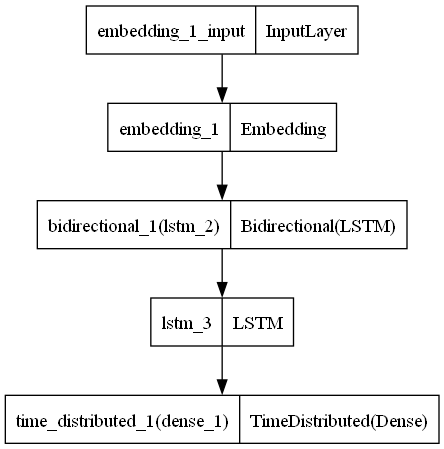

In [18]:
def train_model(X, y, model):
    loss = list()
    for _ in range(15):
        # подходящая модель для одной эпохи в этой последовательности
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss


model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [19]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 63s 2s/step - loss: 0.1698 - accuracy: 0.9678 - val_loss: 0.1644 - val_accuracy: 0.9679


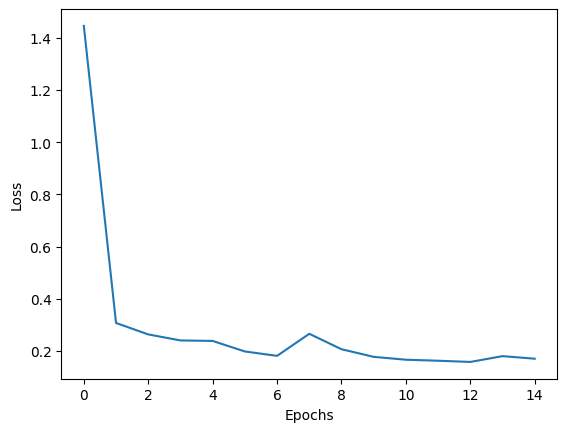

In [20]:
import matplotlib.pyplot as plt

plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

## spaCy

In [21]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

In [22]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [23]:
for w in text.ents:
    print(w.text, w.label_)

Jim PERSON
300 CARDINAL
Acme Corp. ORG
2006 DATE
300 CARDINAL
one CARDINAL
two CARDINAL
NER ORG
English LANGUAGE
MUC-7 ORG
93.39% PERCENT
97.60% PERCENT
96.95%.[1][2 WORK_OF_ART


In [24]:
displacy.render(text, style='ent', jupyter=True)

In [25]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'